In [ ]:
!pip install reportlab
!pip install fpdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=0efaa3cb0ad9e38b1c46bda6c8bd3b95f2a17b817c8a4b6ece71c020d0c65123
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import jarque_bera
import seaborn as sns
from reportlab.lib.pagesizes import letter
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.pdfgen import canvas
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
import tempfile
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfbase import pdfmetrics
from fpdf import FPDF

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
font_path = '/content/drive/My Drive/BigDATA'
all_files = [os.path.join(font_path, f) for f in os.listdir(font_path) if f.endswith('.csv')]

In [ ]:
dataset = os.path.join(font_path, 'ASX_200_historical_data.csv')
dataset = pd.read_csv(dataset, sep=';')
dataset.head()
print(dataset.columns)

Index(['Price,Open,Close'], dtype='object')


In [ ]:
dataset[['Price', 'Open', 'Close']] = dataset['Price,Open,Close'].str.split(',', expand=True)

for col in ['Price', 'Open', 'Close']:
    dataset[col] = pd.to_numeric(dataset[col], errors='coerce')

dataset.drop(columns=['Price,Open,Close'], inplace=True)

print("Updated columns:", dataset.columns)
print(dataset.head())

Updated columns: Index(['Price', 'Open', 'Close'], dtype='object')
   Price         Open        Close
0    NaN          NaN          NaN
1    NaN          NaN          NaN
2    NaN  4648.899902  4705.899902
3    NaN  4705.899902  4740.700195
4    NaN  4740.700195  4723.799805


In [ ]:
dataset = dataset.drop(columns=['Price'])

dataset = dataset.dropna()

print(dataset)

             Open        Close
2     4648.899902  4705.899902
3     4705.899902  4740.700195
4     4740.700195  4723.799805
5     4726.799805  4717.299805
6     4721.399902  4690.299805
...           ...          ...
2777  7537.899902  7504.100098
2778  7504.100098  7501.600098
2779  7501.600098  7561.200195
2780  7561.200195  7614.299805
2781  7614.299805  7590.799805

[2780 rows x 2 columns]


Grouped Frequency Distribution:
Bins
(4656.0, 4986.333]      127
(4986.333, 5316.667]    383
(5316.667, 5647.0]      476
(5647.0, 5977.333]      482
(5977.333, 6307.667]    295
(6307.667, 6638.0]      127
(6638.0, 6968.333]      277
(6968.333, 7298.667]    368
(7298.667, 7629.0]      242
Name: count, dtype: int64


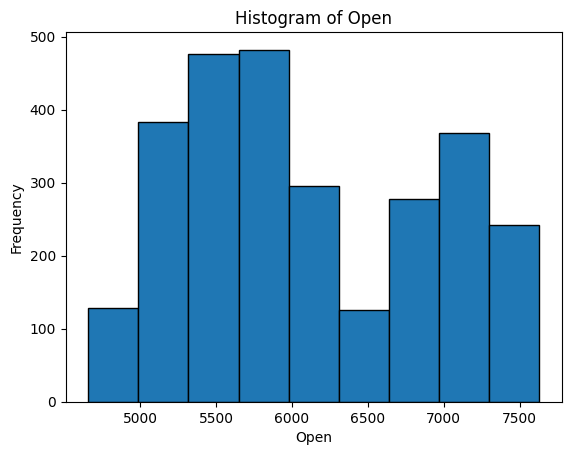

In [ ]:
column_to_analyze = 'Open'
dataset = dataset[dataset[column_to_analyze].notnull()].dropna()
dataset[column_to_analyze] = pd.to_numeric(dataset[column_to_analyze], errors='coerce')

# Define bins for the chosen column
bin_ranges = np.linspace(
    dataset[column_to_analyze].min(),
    dataset[column_to_analyze].max(),
    10
)

# Create grouped frequency distribution
dataset['Bins'] = pd.cut(dataset[column_to_analyze], bins=bin_ranges)
frequency_distribution = dataset['Bins'].value_counts().sort_index()

# Display results
print("Grouped Frequency Distribution:")
print(frequency_distribution)

# Plot histogram
plt.hist(dataset[column_to_analyze], bins=bin_ranges, edgecolor='black')
plt.title(f'Histogram of {column_to_analyze}')
plt.xlabel(column_to_analyze)
plt.ylabel('Frequency')
plt.show()
# Save the plot as an image
image_path = "histogram.png"
plt.savefig(image_path)
plt.close()

We should analyse also "Close" column

SD is used by risk analysts to estimate within which a financial instrument or bond returns are likely to fall.

In [ ]:
# Compute standard deviation for the 'open' column
std_open = dataset['Open'].std()
print(f"Standard Deviation of 'Open': {std_open}")

# Compute standard deviation for the 'Close' column
std_close = dataset['Close'].std()
print(f"Standard Deviation of 'Close': {std_close}")

Standard Deviation of 'Open': 792.1468407890552
Standard Deviation of 'Close': 792.0611540999314


The skewness (3rd moment) is a measure of the asymmetry of the distribution. In risk measurement, it tells us whether the probability of winning is similar to the probability of losing and the nature of losses. Negative skewness means that there is a substantial probability of a big negative return. Positive skewness means that there is a greater-than-normal probability of a big positive return.

In [ ]:
skew_open = dataset['Open'].skew()
print(f"Skewness of 'Open': {skew_open}")

# Compute skewness for the 'Close' column (optional)
skew_close = dataset['Close'].skew()
print(f"Skewness of 'Close': {skew_close}")

def find_if0(skewness):
  if skewness <0:
    print(f"there is a substantial probability of a big negative return")
  if skewness > 0:
    print(f"there is a greater-than-normal probability of a big positive return")
  if skewness == 0:
    print(f"probability of winning is the same as of losing")

print(find_if0(skew_open), find_if0(skew_close))

Skewness of 'Open': 0.2796701752362162
Skewness of 'Close': 0.28060338537807644
there is a greater-than-normal probability of a big positive return
there is a greater-than-normal probability of a big positive return
None None


Kurtosis is useful in describing extreme events (e.g. losses that are so bad that they only have a 1 in 1000 chance of happening).

In the extreme events, the portfolio with the higher kurtosis would suffer worser losses than the portfolio with lower kurtosis.

In [ ]:
# Compute the Coefficient of Variation for the 'Open' column
mean_open = dataset['Open'].mean()
cv_open = (std_open / mean_open) * 100
print(f"Coefficient of Variation for 'Open': {cv_open:.2f}%")

# Compute the Coefficient of Variation for the 'Close' column (optional)
mean_close = dataset['Close'].mean()
cv_close = (std_close / mean_close) * 100
print(f"Coefficient of Variation for 'Close': {cv_close:.2f}%")

kurt_open = dataset['Open'].kurt()
print(f"Kurtosis of 'Open': {kurt_open}")

# Compute Kurtosis for the 'Close' column (optional)
kurt_close = dataset['Close'].kurt()
print(f"Kurtosis of 'Close': {kurt_close}")

def find_if(kurt):
  if kurt <0:
    print(f"distribution is platykurtic , less peakedness and greater coverage of body")
  if kurt > 0:
    print(f"distribution is leptokurtic, fat or long tail but high peakedness")
  if kurt == 0:
    print(f"distribution is mesokurtic , normal shape")

print(find_if(kurt_close), find_if(kurt_open))

Coefficient of Variation for 'Open': 13.00%
Coefficient of Variation for 'Close': 13.00%
Kurtosis of 'Open': -1.202474205062979
Kurtosis of 'Close': -1.203301116121978
distribution is platykurtic , less peakedness and greater coverage of body
distribution is platykurtic , less peakedness and greater coverage of body
None None


It is important to note that positive skewness with low kurtosis series promises high returns.


Under the null hypothesis of a normal distribution, the JB statistic is distributed as chi square with two degrees of freedom. The reported probability is the probability that the Jarque-Bera statistic exceeds (in absolute term) the observed value under null. A small probability value (p < 0.05) will reject the null hypothesis of a normal distribution (null is stated here: there cannot be any distribution other than normal). In our case, since computed JB value is lower than the table value (which is 5.991465 at 5% level of significance and with two degrees of freedom), our p-value is quite higher. One can either look at chi-square table or use excel function = CHIINV(5%,2) to obtain the critical values (i.e. the thumb rule that we normally ask to decide). This indicates that we are not able to reject the null hypothesis. If we reject it, we will commit a type I error (i.e. rejecting a true hypothesis) of 55.15%. Hence, our bond value series surely follows normal distribution. A risk manager will have to fit the series this way before it is used to predict the confidence ranges.

In [ ]:
jb_stat_open, jb_p_value_open = jarque_bera(dataset['Open'])
print(f"Jarque-Bera statistic for 'Open': {jb_stat_open}")
print(f"p-value for 'Open': {jb_p_value_open}")

# Compute Jarque-Bera test for the 'Close' column (optional)
jb_stat_close, jb_p_value_close = jarque_bera(dataset['Close'])
print(f"Jarque-Bera statistic for 'Close': {jb_stat_close}")
print(f"p-value for 'Close': {jb_p_value_close}")

Jarque-Bera statistic for 'Open': 203.68808777728478
p-value for 'Open': 5.884285341792763e-45
Jarque-Bera statistic for 'Close': 204.1601008730411
p-value for 'Close': 4.647264413033196e-45


Quantiles for 'Open':
0.00    4546.000000
0.25    5418.775024
0.50    5926.500000
0.75    6814.550171
1.00    7629.000000
Name: Open, dtype: float64
Quantiles for 'Close':
0.00    4546.000000
0.25    5419.799927
0.50    5927.300049
0.75    6817.525024
1.00    7628.899902
Name: Close, dtype: float64


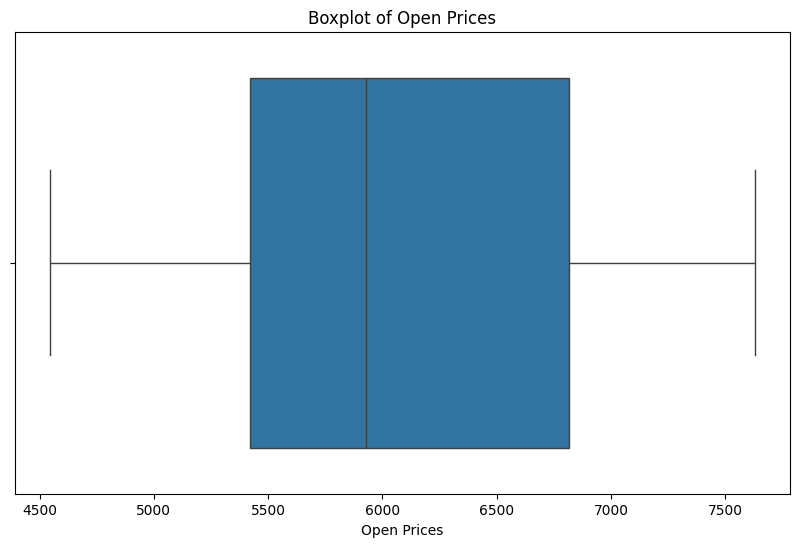

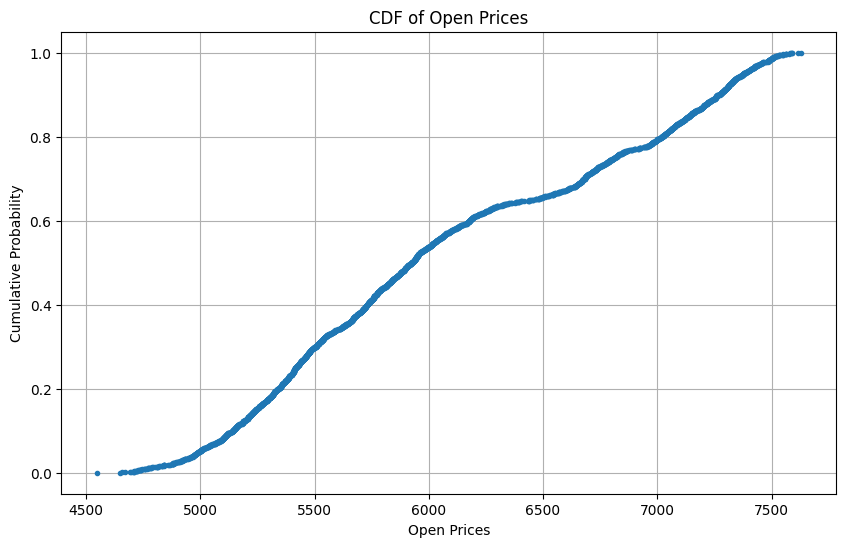

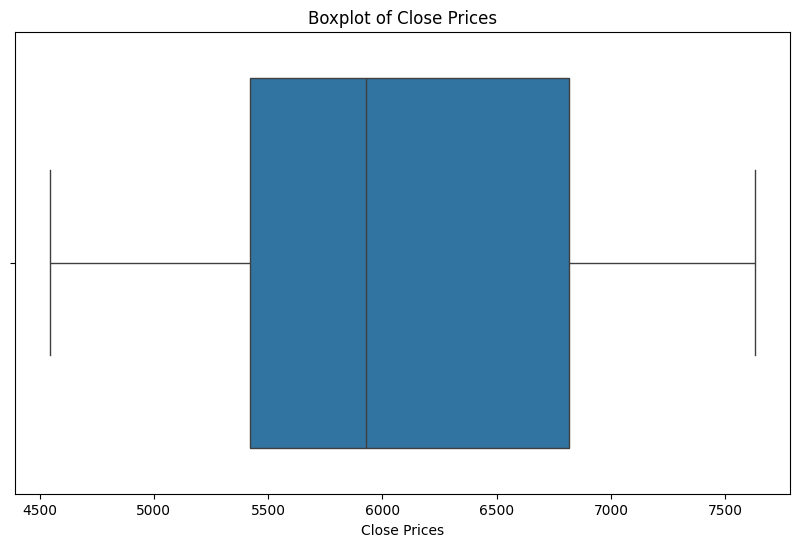

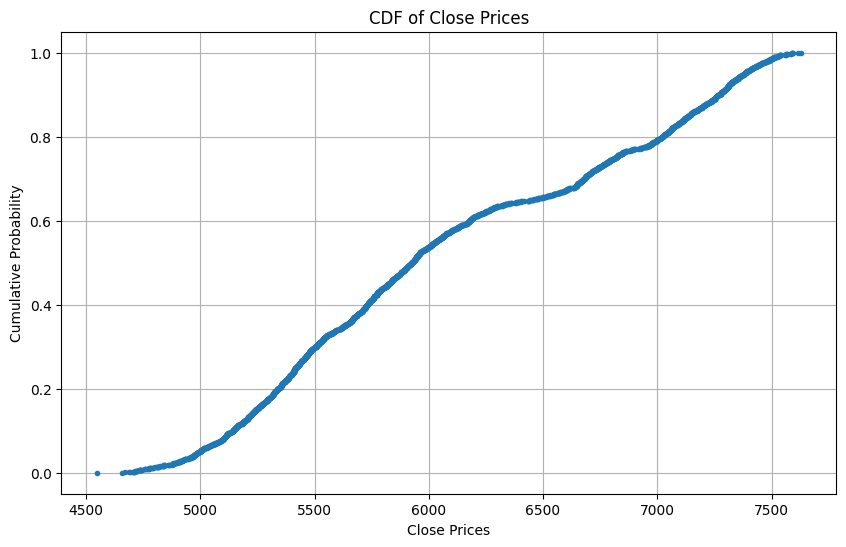

In [ ]:
quantiles_open = dataset['Open'].quantile([0, 0.25, 0.5, 0.75, 1])
print(f"Quantiles for 'Open':\n{quantiles_open}")

# Compute quantiles for 'Close' column (optional)
quantiles_close = dataset['Close'].quantile([0, 0.25, 0.5, 0.75, 1])
print(f"Quantiles for 'Close':\n{quantiles_close}")

# Plot Boxplot to visualize quantiles
plt.figure(figsize=(10, 6))
sns.boxplot(x=dataset['Open'])
plt.title('Boxplot of Open Prices')
plt.xlabel('Open Prices')
plt.show()

# Plot CDF (Cumulative Distribution Function)
plt.figure(figsize=(10, 6))
sorted_open = np.sort(dataset['Open'])
cdf_open = np.arange(1, len(sorted_open)+1) / len(sorted_open)
plt.plot(sorted_open, cdf_open, marker='.', linestyle='none')
plt.title('CDF of Open Prices')
plt.xlabel('Open Prices')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=dataset['Close'])
plt.title('Boxplot of Close Prices')
plt.xlabel('Close Prices')
plt.show()

# Plot CDF (Cumulative Distribution Function) for 'Close' prices
plt.figure(figsize=(10, 6))
sorted_close = np.sort(dataset['Close'])
cdf_close = np.arange(1, len(sorted_close) + 1) / len(sorted_close)
plt.plot(sorted_close, cdf_close, marker='.', linestyle='none')
plt.title('CDF of Close Prices')
plt.xlabel('Close Prices')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()


Gini coefficient is used as a measure of inequality in loan distribution across borrowers, industries, regions, etc. This inequality measures loan concentration risk. Thus, higher is the Gini coefficient, greater is the inequality, and greater is the concentration risk. It is also used to measure discriminatory power of a rating model during model validation.




Gini Coefficient for 'Open': -13994472910.777676
Gini Coefficient for 'Close': -13997032260.118252


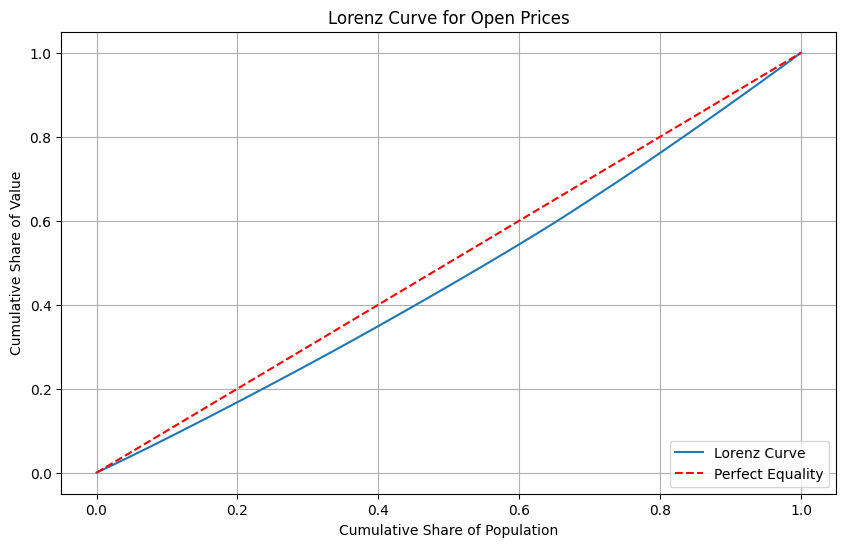

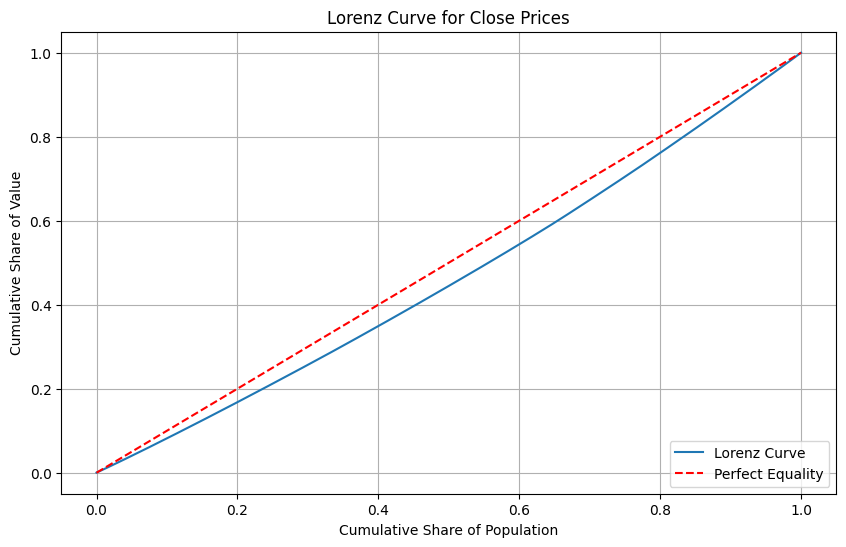

In [ ]:
def gini_coefficient(values):
    sorted_values = np.sort(values)
    n = len(values)
    cumulative_sum = np.cumsum(sorted_values)
    gini = (n + 1 - 2 * np.sum((n - np.arange(1, n+1)) * cumulative_sum)) / n
    return gini

gini_open = gini_coefficient(dataset['Open'])
print(f"Gini Coefficient for 'Open': {gini_open}")

# Calculate the Gini coefficient for 'Close' prices (optional)
gini_close = gini_coefficient(dataset['Close'])
print(f"Gini Coefficient for 'Close': {gini_close}")

# Plot Lorenz Curve for 'Open' prices
sorted_open = np.sort(dataset['Open'])
cumulative_open = np.cumsum(sorted_open) / np.sum(sorted_open)

# Add the line for perfect equality
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0.0, 1.0, len(sorted_open)), cumulative_open, label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color='r', linestyle='--', label='Perfect Equality')
plt.title('Lorenz Curve for Open Prices')
plt.xlabel('Cumulative Share of Population')
plt.ylabel('Cumulative Share of Value')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Lorenz Curve for 'Close' prices (optional)
sorted_close = np.sort(dataset['Close'])
cumulative_close = np.cumsum(sorted_close) / np.sum(sorted_close)

# Add the line for perfect equality
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0.0, 1.0, len(sorted_close)), cumulative_close, label='Lorenz Curve')
plt.plot([0, 1], [0, 1], color='r', linestyle='--', label='Perfect Equality')
plt.title('Lorenz Curve for Close Prices')
plt.xlabel('Cumulative Share of Population')
plt.ylabel('Cumulative Share of Value')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
loan_data = dataset['Close']

sorted_loans = np.sort(loan_data)

total_loan = np.sum(sorted_loans)

deciles = np.percentile(sorted_loans, np.arange(10, 101, 10))

table_data = []

for i in range(10):
    start = int(deciles[i-1]) if i > 0 else 0  # Start of the range
    end = int(deciles[i])  # End of the range
    group_loans = sorted_loans[start:end]
    group_size = len(group_loans)

    group_share = np.sum(group_loans) / total_loan * 100

    avg_loan = np.mean(group_loans)

    cumulative_share = np.sum(sorted_loans[:end]) / total_loan * 100

    cumulative_contribution = 100 * (cumulative_share + (cumulative_share - group_share))

    table_data.append([f'{i*10+1}-{(i+1)*10}', group_share, avg_loan, cumulative_share, cumulative_contribution])

columns = ['Decile Groups', '% Share in Total Loan Size', 'Average Loan (Rs. ’000)',
           'Cumulative % Share in Total Loan Outstanding', '100 × (zi + zi−1)']
loan_distribution_table = pd.DataFrame(table_data, columns=columns)

print(loan_distribution_table)

  Decile Groups  % Share in Total Loan Size  Average Loan (Rs. ’000)  \
0          1-10                       100.0              6093.593096   
1         11-20                         0.0                      NaN   
2         21-30                         0.0                      NaN   
3         31-40                         0.0                      NaN   
4         41-50                         0.0                      NaN   
5         51-60                         0.0                      NaN   
6         61-70                         0.0                      NaN   
7         71-80                         0.0                      NaN   
8         81-90                         0.0                      NaN   
9        91-100                         0.0                      NaN   

   Cumulative % Share in Total Loan Outstanding  100 × (zi + zi−1)  
0                                         100.0            10000.0  
1                                         100.0            20000.0  


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
loan_data = dataset['Open']

sorted_loans = np.sort(loan_data)

total_loan = np.sum(sorted_loans)

deciles = np.percentile(sorted_loans, np.arange(10, 101, 10))

table_data = []

for i in range(10):
    start = int(deciles[i-1]) if i > 0 else 0  # Start of the range
    end = int(deciles[i])  # End of the range
    group_loans = sorted_loans[start:end]
    group_size = len(group_loans)

    group_share = np.sum(group_loans) / total_loan * 100

    avg_loan = np.mean(group_loans)

    cumulative_share = np.sum(sorted_loans[:end]) / total_loan * 100

    cumulative_contribution = 100 * (cumulative_share + (cumulative_share - group_share))

    table_data.append([f'{i*10+1}-{(i+1)*10}', group_share, avg_loan, cumulative_share, cumulative_contribution])

columns = ['Decile Groups', '% Share in Total Loan Size', 'Average Loan (Rs. ’000)',
           'Cumulative % Share in Total Loan Outstanding', '100 × (zi + zi−1)']
loan_distribution_table = pd.DataFrame(table_data, columns=columns)

print(loan_distribution_table)

  Decile Groups  % Share in Total Loan Size  Average Loan (Rs. ’000)  \
0          1-10                       100.0              6092.730179   
1         11-20                         0.0                      NaN   
2         21-30                         0.0                      NaN   
3         31-40                         0.0                      NaN   
4         41-50                         0.0                      NaN   
5         51-60                         0.0                      NaN   
6         61-70                         0.0                      NaN   
7         71-80                         0.0                      NaN   
8         81-90                         0.0                      NaN   
9        91-100                         0.0                      NaN   

   Cumulative % Share in Total Loan Outstanding  100 × (zi + zi−1)  
0                                         100.0            10000.0  
1                                         100.0            20000.0  


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Generowanie raportu

In [ ]:
pdfmetrics.registerFont(TTFont('Arial', 'Arial.ttf'))

def create_plot(data, percentage_difference, title):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(data)), percentage_difference)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Kobiety')
    plt.ylabel('Różnica procentowa')
    plt.title(title)

    # Zapisz wykres do pliku tymczasowego
    tmpfile = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
    plt.savefig(tmpfile.name, bbox_inches='tight')
    plt.close()
    print(f"Saved plot to {tmpfile.name}")  # Debugowanie: wyświetl ścieżkę do pliku
    return tmpfile.name

def create_pdf(raport, std_dev, skewness, kurtosis, coef_of_var, jb_stat, jb_p_value,
               quantiles, frequency_distribution, bin_edges, loan_distribution_table):
    styles = getSampleStyleSheet()
    styleN = ParagraphStyle(
        'Normal',
        parent=styles['Normal'],
        fontName='Arial',
        fontSize=12,
    )

    # Teksty do dodania
    description0 = """ Basic statistics and measures analysis"""
    description1 = f"""SD is used by risk analysts to estimate within which a financial instrument or bond returns are likely to fall."""
    description2 = f"""The skewness (3rd moment) is a measure of the asymmetry of the distribution. In risk measurement, it tells us whether the probability of winning is similar to the probability of losing and the nature of losses. Negative skewness means that there is a substantial probability of a big negative return. Positive skewness means that there is a greater-than-normal probability of a big positive return.It is important to note that positive skewness with low kurtosis series promises high returns."""
    description3 = f"""Under the null hypothesis of a normal distribution, the JB statistic is distributed as chi square with two degrees of freedom. The reported probability is the probability that the Jarque-Bera statistic exceeds (in absolute term) the observed value under null. A small probability value (p < 0.05) will reject the null hypothesis of a normal distribution (null is stated here: there cannot be any distribution other than normal). In our case, since computed JB value is lower than the table value (which is 5.991465 at 5% level of significance and with two degrees of freedom), our p-value is quite higher. One can either look at chi-square table or use excel function = CHIINV(5%,2) to obtain the critical values (i.e. the thumb rule that we normally ask to decide). This indicates that we are not able to reject the null hypothesis. If we reject it, we will commit a type I error (i.e. rejecting a true hypothesis) of 55.15%. Hence, our bond value series surely follows normal distribution. A risk manager will have to fit the series this way before it is used to predict the confidence ranges."""
    description4 = f"""Gini coefficient is used as a measure of inequality in loan distribution across borrowers, industries, regions, etc. This inequality measures loan concentration risk. Thus, higher is the Gini coefficient, greater is the inequality, and greater is the concentration risk. It is also used to measure discriminatory power of a rating model during model validation. gini_value, lorenz_curve_plot,"""
    # Generowanie PDF
    doc = SimpleDocTemplate(raport_Account_Manager, pagesize=letter)

    elements = []

    # Dodawanie wykresu 1
    plot_path1 = create_plot(dataset[column_to_analyze], "Histogram")

    # Dodawanie paragrafu 0
    paragraph1 = Paragraph(description0, styleN)
    elements.append(paragraph1)
    elements.append(Spacer(1, 12))

    # Dodawanie paragrafu 1
    paragraph1 = Paragraph(description1, styleN)
    elements.append(paragraph1)
    elements.append(Spacer(1, 12))

    # Dodawanie wykresu 1
    plot_path1 = create_plot(data1, percentage_difference1, "Procentowa różnica wypłaty ustalonej kobiety od średniej mężczyzn - Dane 1")
    if os.path.exists(plot_path1):
        elements.append(Image(plot_path1, width=400, height=200))
    else:
        print(f"Plot 1 not found: {plot_path1}")

    # Dodawanie paragrafu 2
    paragraph2 = Paragraph(description2, styleN)
    elements.append(paragraph2)
    elements.append(Spacer(1, 12))

    # Dodawanie wykresu 2
    plot_path2 = create_plot(data1_2, percentage_difference2, "Procentowa różnica wypłaty ustalonej kobiety od średniej mężczyzn - Dane 2")
    if os.path.exists(plot_path2):
        elements.append(Image(plot_path2, width=400, height=300))
    else:
        print(f"Plot 2 not found: {plot_path2}")

    # Dodawanie paragrafu 3
    paragraph3 = Paragraph(description3, styleN)
    elements.append(paragraph3)
    elements.append(Spacer(1, 12))

    # Dodawanie wykresu 3
    plot_path3 = create_plot(data1_3, percentage_difference3, "Procentowa różnica wypłaty ustalonej kobiety od średniej mężczyzn - Dane 2")
    if os.path.exists(plot_path3):
        elements.append(Image(plot_path3, width=400, height=300))
    else:
        print(f"Plot 3 not found: {plot_path3}")
    # Dodawanie paragrafu 4
    paragraph4 = Paragraph(description4, styleN)
    elements.append(paragraph4)
    elements.append(Spacer(1, 12))

    # Dodawanie wykresu 3
    plot_path4 = create_plot(data1_4, percentage_difference4, "Procentowa różnica wypłaty ustalonej kobiety od średniej mężczyzn - Dane 2")
    if os.path.exists(plot_path4):
        elements.append(Image(plot_path4, width=400, height=300))
    else:
        print(f"Plot 3 not found: {plot_path4}")
    # Generowanie PDF
    doc.build(elements)
create_pdf("raport_Account_Manager.pdf",data1,data2, percentage_difference1, d1,d2, t_stat1, p_value1, data2_m, data1_m, gender_gap_pay1, gender_gap_pay11)